# Forecaster with Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)

Recurrent Neural Networks (RNN) are a type of neural networks designed to process data that follows a sequential order. In conventional neural networks, such as feedforward networks, information flows in one direction, from input to output through hidden layers, without considering the sequential structure of the data. In contrast, RNNs maintain internal states or memories, which allow them to remember past information and use it to predict future data in the sequence.

The basic unit of an RNN is the recurrent cell. This cell takes two inputs: the current input and the previous hidden state. The hidden state can be understood as a "memory" that retains information from previous iterations. The current input and the previous hidden state are combined to calculate the current output and the new hidden state. This output is used as input for the next iteration, along with the next input in the data sequence.

Despite the advances that have been achieved with RNN architectures, they have limitations to capture long-term patterns. This is why variants such as  Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU) have been developed, which address these problems and allow long-term information to be retained more effectively.

<p align="center"><img src='../img/schema-rnn-model.jpg'style="width: 600px"></p>


<center><font size='2.5'> <i>RNN diagram. Fuente: James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (1st ed.) [PDF]. Springer.</i></font></center>


## Long Short-Term Memory (LSTM)

Long Short-Term Memory (LSTM) neural networks are a specialized type of RNNs designed to overcome the limitations associated with capturing long-term temporal dependencies. Unlike traditional RNNs, LSTMs incorporate a more complex architecture, introducing memory units and gate mechanisms to improve information management over time.

**Structure of LSTMs**

LSTMs have a modular structure consisting of three fundamental gates: the forget gate, the input gate, and the output gate. These gates work together to regulate the flow of information through the memory unit, allowing for more precise control over what information to retain and what to forget.

+ **Forget Gate:** Regulates how much information should be forgotten and how much should be retained, combining the current input and the previous output through a sigmoid function.

+ **Input Gate:** Decides how much new information should be added to long-term memory.

+ **Output Gate:** Determines how much information from the current memory will be used for the final output, combining the current input and memory information through a sigmoid function.



<p align="center"><img src='https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png'style="width: 400px"></p>

<center><font size='2.5'> <i>Diagram of the inputs and outputs of an LSTM. Fuente: codificandobits https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png.</i></font></center>


## Libraries

In [1]:
%load_ext autoreload
%autoreload 2
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('once')

2024-04-16 22:34:47.546039: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 22:34:47.616057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 22:34:47.616101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 22:34:47.618057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 22:34:47.628340: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 22:34:47.629372: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Data

In [2]:
# Data download
# ==============================================================================
air_quality = fetch_dataset(name="air_quality_valencia")

# Data preparation
# ==============================================================================
air_quality = air_quality.interpolate(method="linear")
air_quality = air_quality.sort_index()
air_quality.head()

air_quality_valencia
--------------------
Hourly measures of several air quimical pollutant (pm2.5, co, no, no2, pm10,
nox, o3, so2) at Valencia city.
 Red de Vigilancia y Control de la Contaminación Atmosférica, 46250054-València
- Centre, https://mediambient.gva.es/es/web/calidad-ambiental/datos-historicos.
Shape of the dataset: (26304, 10)


/home/ubuntu/git-repos/skforecast/skforecast/datasets/datasets.py:324: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(freq)


,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
datetime,,,,,,,,,,
2019-01-01 00:00:00,19.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,8.0
2019-01-01 01:00:00,26.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,8.0
2019-01-01 02:00:00,31.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,8.0
2019-01-01 03:00:00,30.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,10.0
2019-01-01 04:00:00,30.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,11.0


In [3]:
# Checking the frequency of the time series
# ==============================================================================
print(f"Index: {air_quality.index.dtype}")
print(f"Frequency: {air_quality.index.freq}")

Index: datetime64[ns]
Frequency: <Hour>


In [4]:
# Split train-validation-test
# ==============================================================================
end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
air_quality_train = air_quality.loc[:end_train, :].copy()
air_quality_val = air_quality.loc[end_train:end_validation, :].copy()
air_quality_test = air_quality.loc[end_validation:, :].copy()

print(
    f"Dates train      : {air_quality_train.index.min()} --- " 
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Dates validation : {air_quality_val.index.min()} --- " 
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Dates test       : {air_quality_test.index.min()} --- " 
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

Dates train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Dates validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Dates test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


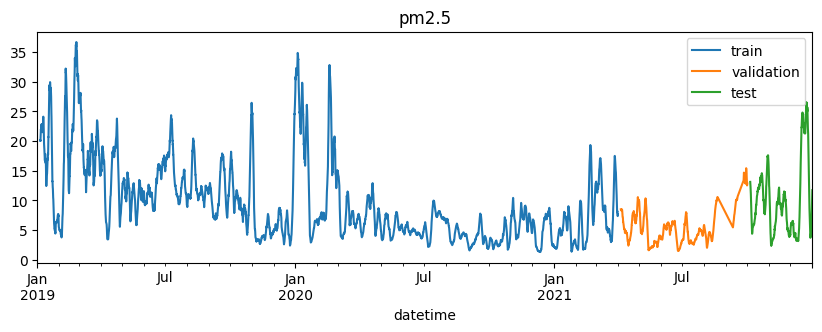

In [5]:
# Plotting one feature
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
air_quality_train["pm2.5"].rolling(100).mean().plot(ax=ax, label="train")
air_quality_val["pm2.5"].rolling(100).mean().plot(ax=ax, label="validation")
air_quality_test["pm2.5"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("pm2.5")
ax.legend();

## Types of problems in time series modeling

### 1:1 Single-Step Forecasting - Model a single series and predict that same series using one step ahead.

This type of problem involves modeling a time series using only its past. It is a typical autoregressive problem.

Although tensorflow-keras facilitates the process of creating *deep learning* architectures, it is not always trivial to determine the dimensions that an LSTM model should have for forecasting, as these depend on how many time series are being modeled, how many are being predicted, and the length of the prediction horizon.


<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The `create_and_compile_model` function is designed to facilitate the creation of the Tensorflow model, however, more advanced users can create their own architectures as long as the input and output dimensions match the use case to which the model will be applied.

</div>

In [6]:
# Create model
# ==============================================================================
series = ["o3"] # Series used as predictors
levels = ["o3"] # Target serie to predict
lags = 32 # Past time steps to be used to predict the target
steps = 1 # Future time steps to be predicted

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
 reshape (Reshape)           (None, 1, 1)              0         
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193 (772.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



To improve the user experience and speed up the prototyping, development, and production process, skforecast has the `create_and_compile_model` function, with which, by indicating just a few arguments, the architecture is inferred and the model is created.

+ `series`: Time series to be used to train the model

+ `levels`: Time series to be predicted.
  
+ `lags`: Number of time steps to be used to predict the next value.

+ `steps`: Number of time steps to be predicted.

+ `recurrent_layer`: Type of recurrent layer to use. By default, an LSTM layer is used.
  
+ `recurrent_units`: Number of units in the recurrent layer. By default, 100 is used. If a list is passed, a recurrent layer will be created for each element in the list.

+ `dense_units`: Number of units in the dense layer. By default, 64 is used. If a list is passed, a dense layer will be created for each element in the list.
  
+ `optimizer`: Optimizer to use. By default, Adam with a learning rate of 0.01 is used.
  
+ `loss`: Loss function to use. By default, Mean Squared Error is used.


In [7]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,  # Number of epochs to train the model.
        "batch_size": 32,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)    

forecaster

/home/ubuntu/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:220: UserWarning: Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.
  warnings.warn(
/home/ubuntu/git-repos/skforecast/skforecast/ForecasterRnn/ForecasterRnn.py:247: UserWarning: `steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.
  warnings.warn(


ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x791bb053e410> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm', 'trainable': True, 'dtype': 'float32', 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 4, 'a

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>


The warning indicates that the number of lags has been inferred from the model architecture. In this case, the model has an LSTM layer with 32 neurons, so the number of lags is 32. If a different number of lags is desired, the `lags` argument can be specified in the `create_and_compile_model` function.
To omit the warning, the `lags=lags` and `steps=steps` arguments can be specified in the initialization of the `ForecasterRnn`.

</div>

In [8]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10


615/615 [==============================] - 8s 10ms/step - loss: 0.0177 - val_loss: 0.0080
Epoch 2/10
615/615 [==============================] - 6s 9ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 3/10
615/615 [==============================] - 6s 9ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 4/10
615/615 [==============================] - 6s 9ms/step - loss: 0.0057 - val_loss: 0.0076
Epoch 5/10
615/615 [==============================] - 6s 9ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 6/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0055 - val_loss: 0.0060
Epoch 7/10
615/615 [==============================] - 6s 9ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 8/10
615/615 [==============================] - 6s 9ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 9/10
615/615 [==============================] - 6s 9ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 10/10
615/615 [==============================] - 6s 9ms/step - loss: 0.0055 - val_loss: 0.0059


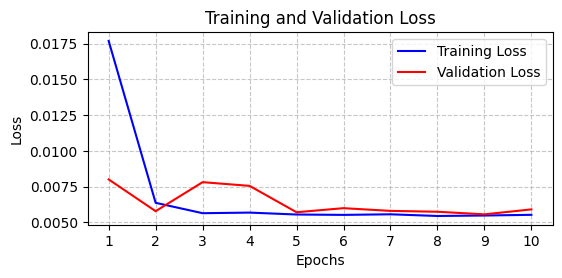

In [17]:
# Track training and overfitting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

Once the forecaster has been trained, predictions can be obtained. In this case, it is a single value since only one step into the future (`step`) has been specified.

In [18]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01,45.996216


In [19]:
# Backtesting with test data
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]), # Training + Validation Data
    metric="mean_absolute_error",
    verbose=True,
    refit=False,
)

AttributeError: 'ForecasterRnn' object has no attribute 'dropna_from_series'

In [41]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,54.612850
2021-10-01 01:00:00,59.209904
2021-10-01 02:00:00,63.077805
2021-10-01 03:00:00,63.108265
2021-10-01 04:00:00,53.347530
...,...
2021-12-31 19:00:00,17.557945
2021-12-31 20:00:00,16.834385
2021-12-31 21:00:00,17.608961
2021-12-31 22:00:00,17.318754


In [44]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Media de la serie: 54.52
Error (mae) relativo: 10.88 %


### 1:1 Multiple-Step Forecasting - Model a single series and predict that same series, predicting multiple steps.


The next case is to predict the next 5 values of O3 using only its historical data. It is therefore a scenario in which multiple future steps of a single time series are modeled using only its past values.

A similar architecture to the previous one will be used, but with a greater number of neurons in the LSTM layer and in the first dense layer. This will allow the model to have greater flexibility to model the time series.

In [20]:
# Model creation
# ==============================================================================
series = ["o3"] # Series used as predictors
levels = ["o3"] # Target serie to predict
lags = 32 # Past time steps to be used to predict the target
steps = 5 # Future time steps to be predicted


model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=50,
    dense_units=32,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 32)                1632      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
 reshape_1 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 12197 (47.64 KB)
Trainable params: 12197 (47.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 3,  # Number of epochs to train the model.
        "batch_size": 32,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)    

forecaster

ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x791b744d9710> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}, 'registered_name': None, 'name': 'input_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_1', 'trainable': True, 'dtype': 'float32', 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'u

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The `fit_kwargs` parameter is very useful as it allows you to set any configuration in the model, in this case Keras. In the previous code, the number of training epochs (10) is defined with a batch size of 32. An `EarlyStopping` callback is configured to stop training when the validation loss stops decreasing for 5 epochs (`patience=5`). Other callbacks can also be configured, such as `ModelCheckpoint` to save the model at each epoch, or even Tensorboard to visualize the training and validation loss in real time.

</div>



In [23]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/3


615/615 [==============================] - 10s 14ms/step - loss: 0.0198 - val_loss: 0.0123
Epoch 2/3
615/615 [==============================] - 8s 13ms/step - loss: 0.0130 - val_loss: 0.0125
Epoch 3/3
615/615 [==============================] - 8s 13ms/step - loss: 0.0118 - val_loss: 0.0112


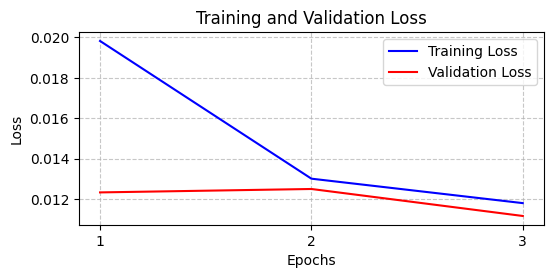

In [24]:
# Train and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

It is anticipated that the prediction will be of lower quality than in the previous case, as the error observed in the different epochs is higher. This has a simple explanation, and that is that the model has to predict 5 values instead of 1. Therefore, the validation error is higher since the loss of 5 values is being calculated instead of 1.

The prediction is made. In this case, there are 5 values since 5 steps into the future (`step`) have been specified.

In [25]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01 00:00:00,44.907246
2021-04-01 01:00:00,44.057590
2021-04-01 02:00:00,43.550949
2021-04-01 03:00:00,40.817284
2021-04-01 04:00:00,39.695187


In [26]:
# Specific step predictions
# ==============================================================================
predictions = forecaster.predict(steps=[1, 3])
predictions

,o3
2021-04-01 00:00:00,44.907246
2021-04-01 02:00:00,43.550949


In [51]:
# Backtesting 
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]),
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/10
752/752 [==============================] - 11s 14ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 2/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 3/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 4/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0112 - val_loss: 0.0122
Epoch 5/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 6/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 7/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 8/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 9/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 10/10
752/752 [==============================] - 10s 13ms/step - loss: 0.010

  0%|          | 0/442 [00:00<?, ?it/s]

In [52]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,57.380260
2021-10-01 01:00:00,54.153625
2021-10-01 02:00:00,51.160664
2021-10-01 03:00:00,48.591709
2021-10-01 04:00:00,47.653816
...,...
2021-12-31 19:00:00,18.126362
2021-12-31 20:00:00,20.011911
2021-12-31 21:00:00,12.303537
2021-12-31 22:00:00,15.502289


In [53]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['o3'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['o3'], name="predictions", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Prediction vs real values in the test set",
    xaxis_title="Date time",
    yaxis_title="O3",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.05,
        xanchor="left",
        x=0
    )
)
fig.show()

In [54]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,9.548553


In [55]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Media de la serie: 54.52
Error mse relativo: 17.51 %


In this case, the prediction is worse than in the previous case. This is to be expected since the model has to predict 5 values instead of 1.

### N:1 Multiple-Step Forecasting - Multiple time series with single output

In this case, the same series will be predicted, but using multiple time series as predictors. It is therefore a scenario in which past values of multiple time series are used to predict a single time series.

These types of approaches are very useful when multiple time series related to each other are available. For example, in the case of temperature prediction, multiple time series such as humidity, atmospheric pressure, wind speed, etc. can be used.

In [56]:
# Model creation
# ==============================================================================
# Time series used in the training. Now, it is multiseries
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.','so2'] 
levels = ["o3"] 
lags = 32 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 10)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 32, 100)           44400     
                                                                 
 lstm_4 (LSTM)               (None, 50)                30200     
                                                                 
 dense_6 (Dense)             (None, 64)                3264      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 5)                 165       
                                                                 
 reshape_3 (Reshape)         (None, 5, 1)              0   

In [57]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 4,  
        "batch_size": 128,  
        "series_val": data_val,
    },
)
forecaster

ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x7f12859e5550> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model_3', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_4'}, 'registered_name': None, 'name': 'input_4', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_3', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'u

In [58]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/4
154/154 [==============================] - 16s 84ms/step - loss: 0.0303 - val_loss: 0.0172
Epoch 2/4
154/154 [==============================] - 12s 81ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 3/4
154/154 [==============================] - 12s 81ms/step - loss: 0.0112 - val_loss: 0.0128
Epoch 4/4
154/154 [==============================] - 12s 81ms/step - loss: 0.0102 - val_loss: 0.0127


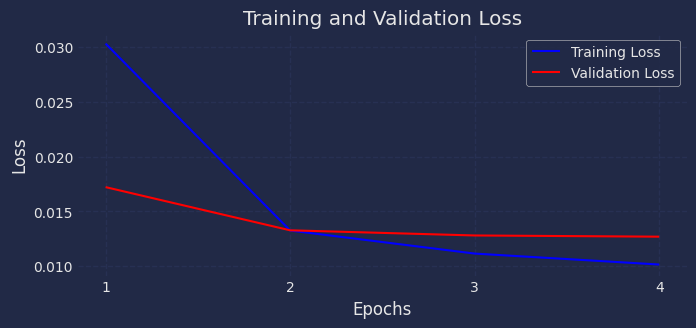

In [59]:
# Trainig and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
forecaster.plot_history(ax=ax)

In [60]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01 00:00:00,46.124866
2021-04-01 01:00:00,42.240002
2021-04-01 02:00:00,37.344341
2021-04-01 03:00:00,33.136936
2021-04-01 04:00:00,30.883102


In [61]:
# Backtesting with test data
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/4
188/188 [==============================] - 17s 82ms/step - loss: 0.0098 - val_loss: 0.0110
Epoch 2/4
188/188 [==============================] - 15s 80ms/step - loss: 0.0095 - val_loss: 0.0121
Epoch 3/4
188/188 [==============================] - 15s 80ms/step - loss: 0.0092 - val_loss: 0.0112
Epoch 4/4
188/188 [==============================] - 16s 84ms/step - loss: 0.0091 - val_loss: 0.0104


  0%|          | 0/442 [00:00<?, ?it/s]

In [62]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,9.97027


In [63]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Media de la serie: 54.52
Error mse relativo: 18.29 %


In [64]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,52.007599
2021-10-01 01:00:00,49.981213
2021-10-01 02:00:00,45.591721
2021-10-01 03:00:00,44.655510
2021-10-01 04:00:00,40.639957
...,...
2021-12-31 19:00:00,22.764130
2021-12-31 20:00:00,12.558327
2021-12-31 21:00:00,7.684178
2021-12-31 22:00:00,6.449364


In [65]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['o3'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['o3'], name="predictions", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Prediction vs real values in the test set",
    xaxis_title="Date time",
    yaxis_title="O3",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.05,
        xanchor="left",
        x=0
    )
)
fig.show()

### N:M Multiple-Step Forecasting - Multiple time series with multiple outputs

In the next and last scenario, multiple time series are predicted using multiple time series as predictors. It is therefore a scenario in which multiple series are modeled simultaneously using a single model. This has special application in many real scenarios, such as the prediction of stock values for several companies based on the stock history, the price of energy and commodities. Or the case of forecasting multiple products in an online store, based on the sales of other products, the price of the products, etc.

In [66]:
# Model creation
# ==============================================================================
# Now, we have multiple series and multiple targets
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.','so2'] 
levels = ['pm2.5', 'co', 'no', "o3"] #  Features to predict. It can be all the series or less
lags = 32 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 10)]          0         
                                                                 
 lstm_5 (LSTM)               (None, 32, 100)           44400     
                                                                 
 lstm_6 (LSTM)               (None, 50)                30200     
                                                                 
 dense_9 (Dense)             (None, 64)                3264      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 20)                660       
                                                                 
 reshape_4 (Reshape)         (None, 5, 4)              0   

In [67]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 100, 
        "batch_size": 128, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  
        "series_val": data_val,
    },
)
forecaster

ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x7f1285c66f50> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['pm2.5', 'co', 'no', 'o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model_4', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_5'}, 'registered_name': None, 'name': 'input_5', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_5', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 't

The model is trained for 100 epochs with an `EarlyStopping` callback that stops training when the validation loss stops decreasing for 5 epochs (`patience=5`).

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

Training the model takes approximately 3 minutes on a computer with 8 cores, and the `EarlyStopping` stops training at epoch 11. These results may vary depending on the hardware used.

In [68]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/100
154/154 [==============================] - 16s 86ms/step - loss: 0.0114 - val_loss: 0.0122
Epoch 2/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 3/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0044 - val_loss: 0.0092
Epoch 4/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0041 - val_loss: 0.0082
Epoch 5/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0039 - val_loss: 0.0074
Epoch 6/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0038 - val_loss: 0.0076
Epoch 7/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0037 - val_loss: 0.0072
Epoch 8/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 9/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 10/100
154/154 [==============================] - 12s 81ms/step - l

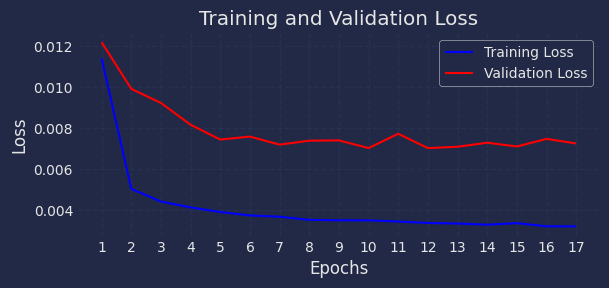

In [69]:
# Trainig and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

In [70]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,pm2.5,co,no,o3
2021-04-01 00:00:00,12.820191,0.109160,1.248160,38.645088
2021-04-01 01:00:00,13.549714,0.117340,3.352049,36.810040
2021-04-01 02:00:00,13.048641,0.117833,2.109012,34.212204
2021-04-01 03:00:00,12.001824,0.117750,2.290622,39.499146
2021-04-01 04:00:00,11.314098,0.101048,0.168339,43.080688


The prediction can also be made for specific `steps`, as long as they are within the prediction horizon defined in the model.

In [71]:
# Specific step predictions
# ==============================================================================
forecaster.predict(steps=[1, 5], levels="o3")

,o3
2021-04-01 00:00:00,38.645088
2021-04-01 04:00:00,43.080688


In [72]:
# Backtesting with test data
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]),
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/100
188/188 [==============================] - 17s 82ms/step - loss: 0.0032 - val_loss: 0.0071
Epoch 2/100
188/188 [==============================] - 15s 80ms/step - loss: 0.0031 - val_loss: 0.0070
Epoch 3/100
188/188 [==============================] - 15s 80ms/step - loss: 0.0031 - val_loss: 0.0072
Epoch 4/100
188/188 [==============================] - 15s 80ms/step - loss: 0.0031 - val_loss: 0.0073
Epoch 5/100
188/188 [==============================] - 15s 81ms/step - loss: 0.0030 - val_loss: 0.0071
Epoch 6/100
188/188 [==============================] - 15s 80ms/step - loss: 0.0031 - val_loss: 0.0084
Epoch 7/100
188/188 [==============================] - 15s 80ms/step - loss: 0.0030 - val_loss: 0.0078


  0%|          | 0/442 [00:00<?, ?it/s]

In [73]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,pm2.5,3.538131
1,co,0.025320
2,no,2.838939
3,o3,11.728837


In [121]:
# Plotting predictions vs real values in the test set
# =============================================================================
fig = px.line(
    data_frame = pd.concat([
                    predictions.melt(ignore_index=False).assign(group="predicciones"),
                    data_test[predictions.columns].melt(ignore_index=False).assign(group="test")
                ]).reset_index().rename(columns={"index": "date_time"}),
    x="date_time",
    y="value",
    facet_row="variable",
    color="group",
    title="Predictions vs real values in the test set",
)

fig.update_layout(
    title="Predicciones vs valores reales en el conjunto de test",
    title="Prediction vs real values in the test set",
    width=800,
    height=850,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0
    )
)

fig.update_yaxes(matches=None)